In [180]:
#| warning: false
library(dplyr)
library(dtplyr)
library(data.table)
library(lubridate)
library(PerformanceAnalytics)
library(xts)
library(zoo) # to apply rolling functions
library(ggplot2)
options(warn=-1)
source("functions.R")

In [147]:
data = fread("compustat_daily_2010_2025.csv")
data = data %>% 
    mutate(datadate = as.Date(datadate, format = "%m/%d/%Y"))
glimpse(data)

Rows: 783,992
Columns: 20
$ tic      <chr> "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR", "AIR"…
$ datadate <date> 2010-01-04, 2010-01-05, 2010-01-06, 2010-01-07, 2010-01-08, …
$ conm     <chr> "AAR CORP", "AAR CORP", "AAR CORP", "AAR CORP", "AAR CORP", "…
$ exchg    <int> 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1…
$ add1     <chr> "One AAR Place, 1100 North Wood Dale Road", "One AAR Place, 1…
$ addzip   <chr> "60191", "60191", "60191", "60191", "60191", "60191", "60191"…
$ busdesc  <chr> "AAR Corp. provides products and services to commercial aviat…
$ city     <chr> "Wood Dale", "Wood Dale", "Wood Dale", "Wood Dale", "Wood Dal…
$ conml    <chr> "AAR Corp", "AAR Corp", "AAR Corp", "AAR Corp", "AAR Corp", "…
$ fax      <chr> "630 227 2039", "630 227 2039", "630 227 2039", "630 227 2039…
$ loc      <chr> "USA", "USA", "USA", "USA", "USA", "USA", "USA", "USA", "USA"…
$ phone    <chr> "630 227 2000", "630 227 2000", "630 227 2000", "630 227 2000…
$ sic      <in

## Clean the data as needed and display the br(head of the data, showing columns relevant to the below analysis.)
up to toss: weburl, prchd, prcld, prcod, gvkey, addzip, add1, exchg (?), cshtrd (?)

In [148]:
data_pfe = data %>% 
    filter(tic == "PFE") %>% 
    na.omit() %>% 
    arrange(tic, datadate)
head(data_pfe)


tic,datadate,conm,exchg,add1,addzip,busdesc,city,conml,fax,loc,phone,sic,weburl,cshtrd,prccd,prchd,prcld,prcod,gvkey
<chr>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
PFE,2010-01-04,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,USA,212 733 2323,2834,www.pfizer.com,52074710,18.93,18.94,18.235,18.27,8530
PFE,2010-01-05,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,USA,212 733 2323,2834,www.pfizer.com,43368460,18.66,18.93,18.550,18.92,8530
PFE,2010-01-06,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,USA,212 733 2323,2834,www.pfizer.com,41405070,18.60,18.81,18.510,18.66,8530
PFE,2010-01-07,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,USA,212 733 2323,2834,www.pfizer.com,39427720,18.53,18.67,18.460,18.64,8530
PFE,2010-01-08,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,USA,212 733 2323,2834,www.pfizer.com,30403370,18.68,18.71,18.520,18.62,8530
PFE,2010-01-11,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,USA,212 733 2323,2834,www.pfizer.com,32442710,18.83,18.95,18.670,18.83,8530


## Plot the autocorrelation function of simple daily returns.

Calculate simple daily returns

In [149]:
data_pfe = data_pfe %>% 
    mutate(simple_d_r = prccd / lag(prccd) - 1) %>% 
    na.omit()
glimpse(data_pfe)

Rows: 3,980
Columns: 21
$ tic        <chr> "PFE", "PFE", "PFE", "PFE", "PFE", "PFE", "PFE", "PFE", "PF…
$ datadate   <date> 2010-01-05, 2010-01-06, 2010-01-07, 2010-01-08, 2010-01-11…
$ conm       <chr> "PFIZER INC", "PFIZER INC", "PFIZER INC", "PFIZER INC", "PF…
$ exchg      <int> 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,…
$ add1       <chr> "66 Hudson Boulevard East", "66 Hudson Boulevard East", "66…
$ addzip     <chr> "10001-2192", "10001-2192", "10001-2192", "10001-2192", "10…
$ busdesc    <chr> "Pfizer Inc. discovers, develops, manufactures, markets, di…
$ city       <chr> "New York", "New York", "New York", "New York", "New York",…
$ conml      <chr> "Pfizer Inc", "Pfizer Inc", "Pfizer Inc", "Pfizer Inc", "Pf…
$ fax        <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "", "",…
$ loc        <chr> "USA", "USA", "USA", "USA", "USA", "USA", "USA", "USA", "US…
$ phone      <chr> "212 733 2323", "212 733 2323", "212 733 2323", "212 733 23…
$ sic        <in

Plot autocorrelation function for simple daily returns

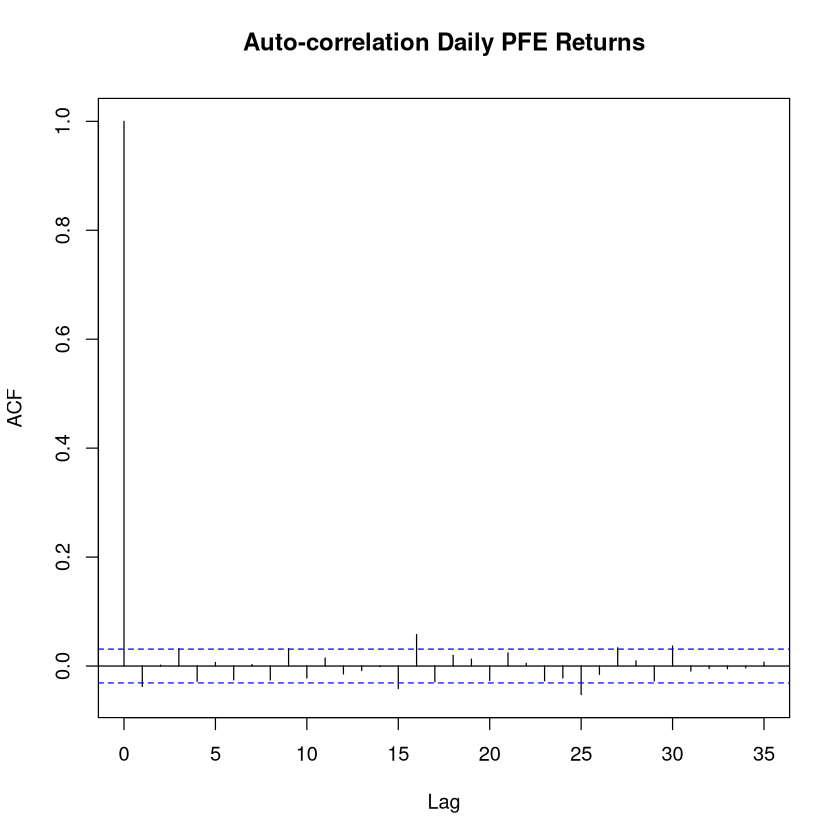

In [150]:
#| tbl-cap: "Auto-correlation PFE Simple Daily Returns"
acf(data_pfe$simple_d_r,
    main = "Auto-correlation Daily PFE Returns")

calculate simple weekly returns (friday on friday)

In [151]:
#| tbl-cap: "Simple weekly returns for PFE"
data_pfe_weekly = data_pfe %>% 
    ## determine weekly returns based on fridays
    group_by(tic, datadate = floor_date(datadate, "week")+5) %>%
    summarise(weekly_close = last(prccd)) %>%
    arrange(tic, datadate) %>%
    group_by(tic) %>%
    mutate(simple_w_r = (weekly_close / lag(weekly_close)) - 1) %>%
    ungroup() %>% 
    na.omit()
head(data_pfe_weekly)

`summarise()` has grouped output by 'tic'. You can override using the `.groups`
argument.


tic,datadate,weekly_close,simple_w_r
<chr>,<date>,<dbl>,<dbl>
PFE,2010-01-15,19.49,0.043361884
PFE,2010-01-22,18.96,-0.027193433
PFE,2010-01-29,18.66,-0.015822785
PFE,2010-02-05,17.96,-0.037513398
PFE,2010-02-12,17.80,-0.008908686
PFE,2010-02-19,17.99,0.010674157


this approach is robust even when some fridays didnt have trading, since the closing price on that given day will still be recorded as that of the previous day. see below for proof:

In [152]:
data_pfe_check <- data %>%
  filter(tic == "PFE") %>%    
  arrange(datadate) %>%       
  mutate(
    weekday = wday(datadate, label = TRUE),
    prev_date = lag(datadate),   
    prev_price = lag(prccd),     
    unchanged = !is.na(prccd) & (prccd == prev_price)  # either TRUE or FALSE, depends on if friday price equals previous trading day's price
  ) %>%
  # keep fridays where price is unchanged
  filter(weekday == "Fri" & unchanged == TRUE) %>%
  select(prev_date, prev_price, friday_date = datadate, friday_price = prccd)

head(data_pfe_check)


prev_date,prev_price,friday_date,friday_price
<date>,<dbl>,<date>,<dbl>
2011-11-23,18.45,2011-11-25,18.45
2012-10-11,25.12,2012-10-12,25.12
2012-11-01,24.55,2012-11-02,24.55
2013-10-24,30.61,2013-10-25,30.61
2013-12-12,30.25,2013-12-13,30.25
2015-03-12,34.00,2015-03-13,34.00


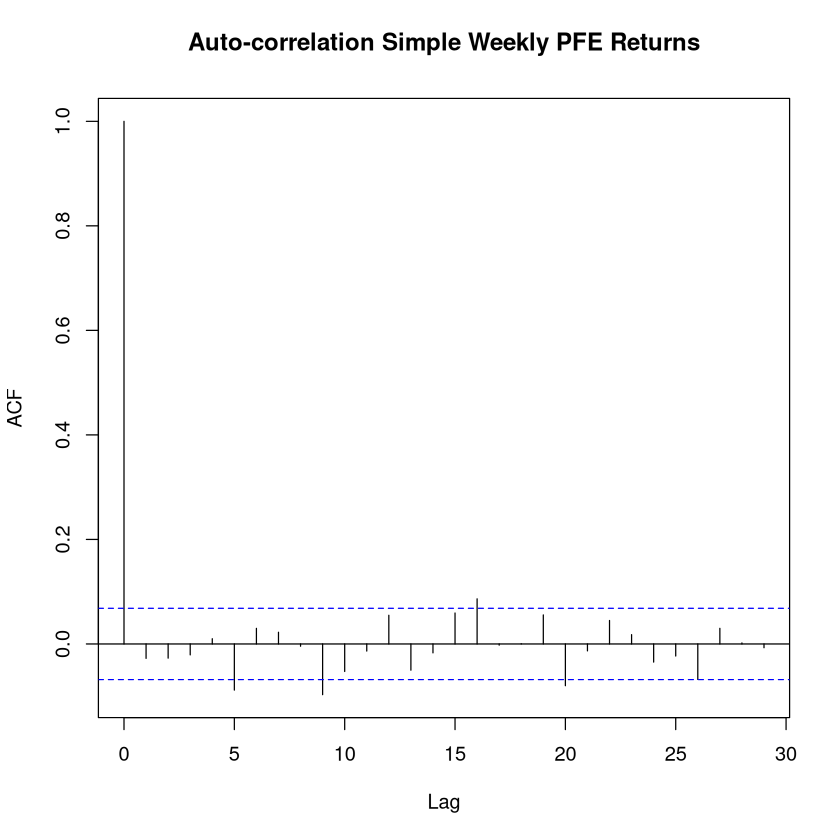

In [153]:
#| tbl-cap: "Auto-correlation PFE Simple Weekly Returns"
acf(data_pfe_weekly$simple_w_r,
    main = "Auto-correlation Simple Weekly PFE Returns")

Calculate mean weekly returns

In [154]:
#| tbl-cap: "Mean weekly returns for PFE"
data_pfe_m_weekly = data_pfe %>% 
    ## enclose weeks
    group_by(tic, week = floor_date(datadate, "week")) %>%
    summarise(mean_w_r = mean(simple_d_r)) %>%
    na.omit()
head(data_pfe_m_weekly)

`summarise()` has grouped output by 'tic'. You can override using the `.groups`
argument.


tic,week,mean_w_r
<chr>,<date>,<dbl>
PFE,2010-01-03,-0.003286742
PFE,2010-01-10,0.008562150
PFE,2010-01-17,-0.006622766
PFE,2010-01-24,-0.003132801
PFE,2010-01-31,-0.007375525
PFE,2010-02-07,-0.001771689


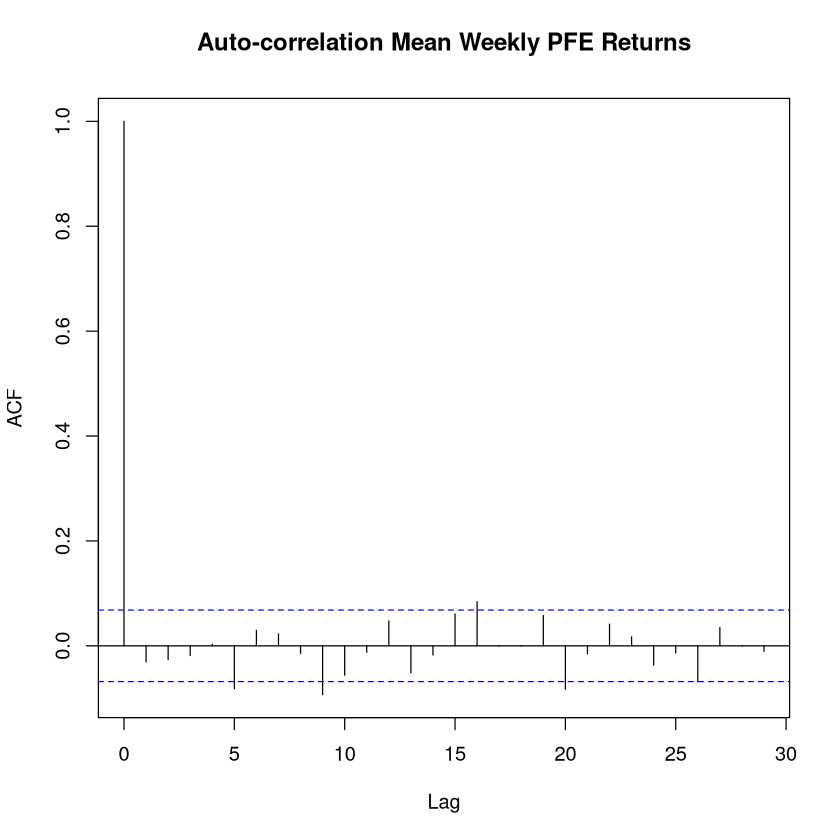

In [155]:
#| tbl-cap: "Auto-correlation PFE Mean Weekly Returns"
acf(data_pfe_m_weekly$mean_w_r,
    main = "Auto-correlation Mean Weekly PFE Returns")

Now to find a moderate, statistically significant autocorrelation at magnitude greater than 0.2

In [156]:
acf_values <- acf(data_pfe_m_weekly$mean_w_r, plot = FALSE)

# Create a tidy data frame of lag and correlation
acf_df <- data.frame(
  lag = acf_values$lag[-1],       # remove lag 0
  acf = acf_values$acf[-1]        # remove lag 0 correlation = 1
)

acf_df[1:10,]

acf_df_abs_order = acf_df %>% 
    mutate(acf_abs = abs(acf)) %>% 
    arrange(desc(acf_abs))

# Show acf in order of absolute value
acf_df_abs_order

# Highlight acf exceeding ±0.2
acf_df %>%
  filter(abs(acf) > 0.2)


,lag,acf
,<dbl>,<dbl>
1,1,-0.030696396
2,2,-0.026001351
3,3,-0.018298858
4,4,0.002669626
5,5,-0.081860524
6,6,0.029623351
7,7,0.022711484
8,8,-0.014585953
9,9,-0.093112210


lag,acf,acf_abs
<dbl>,<dbl>,<dbl>
9,-0.0931122101,0.0931122101
16,0.0840567033,0.0840567033
20,-0.0825529753,0.0825529753
5,-0.0818605240,0.0818605240
26,-0.0685098289,0.0685098289
15,0.0606934570,0.0606934570
19,0.0576887537,0.0576887537
10,-0.0560049977,0.0560049977
13,-0.0515775506,0.0515775506


lag,acf
<dbl>,<dbl>


Answer: there is no statistically significant autocorrelation (magnitude greater than 0.2) for mean weekly returns of PFE

## Prepare for the Moving Average Crossover Strategy by subsetting your data to look only at data from 2020-01-01 onwards. The rest of the tasks in this project will use this subset

select only data from 2020-01-01 onwards

In [157]:
data_pfe_2020 = data_pfe %>% 
    filter(datadate >= "2020-01-01")
head(data_pfe_2020)

tic,datadate,conm,exchg,add1,addzip,busdesc,city,conml,fax,⋯,phone,sic,weburl,cshtrd,prccd,prchd,prcld,prcod,gvkey,simple_d_r
<chr>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
PFE,2020-01-02,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,⋯,212 733 2323,2834,www.pfizer.com,15667930,39.14,39.35,38.875,39.30,8530,-0.001020929
PFE,2020-01-03,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,⋯,212 733 2323,2834,www.pfizer.com,14158250,38.93,39.24,38.670,38.72,8530,-0.005365355
PFE,2020-01-06,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,⋯,212 733 2323,2834,www.pfizer.com,13547080,38.88,39.00,38.700,38.82,8530,-0.001284357
PFE,2020-01-07,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,⋯,212 733 2323,2834,www.pfizer.com,19083070,38.75,39.13,38.680,39.12,8530,-0.003343621
PFE,2020-01-08,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,⋯,212 733 2323,2834,www.pfizer.com,15563050,39.06,39.22,38.750,38.76,8530,0.008000000
PFE,2020-01-09,PFIZER INC,11,66 Hudson Boulevard East,10001-2192,"Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products in the United States and internationally.",New York,Pfizer Inc,,⋯,212 733 2323,2834,www.pfizer.com,20846030,38.89,39.27,38.790,39.27,8530,-0.004352279


In [158]:
df_pfe_slow_fast_ma = data_pfe_2020 %>% 
  group_by(tic) %>%
  mutate(fast_ma = f_fast_MA(prccd)) %>%
  mutate(slow_ma = f_slow_MA(prccd, 200)) %>%
  mutate(row_num = row_number()) %>%
  select(row_num, datadate, tic, prccd, fast_ma, slow_ma)
  
df_1 = df_pfe_slow_fast_ma %>% 
  slice(49:51) 

df_2 = df_pfe_slow_fast_ma %>% 
  slice(199:201)

df_1
df_2


row_num,datadate,tic,prccd,fast_ma,slow_ma
<int>,<date>,<chr>,<dbl>,<dbl>,<dbl>
49,2020-03-12,PFE,30.02,NA,NA
50,2020-03-13,PFE,32.71,37.1338,NA
51,2020-03-16,PFE,30.18,36.9546,NA


row_num,datadate,tic,prccd,fast_ma,slow_ma
<int>,<date>,<chr>,<dbl>,<dbl>,<dbl>
199,2020-10-14,PFE,36.86,37.1590,NA
200,2020-10-15,PFE,36.55,37.1210,36.25265
201,2020-10-16,PFE,37.95,37.1146,36.24670


Create a custom function in a .R script to generate buy and sell signals.
Create a custom function in a .R script to backtest your strategy.
Using your functions, generate signals and backtest the strategy, plotting the performance summary.

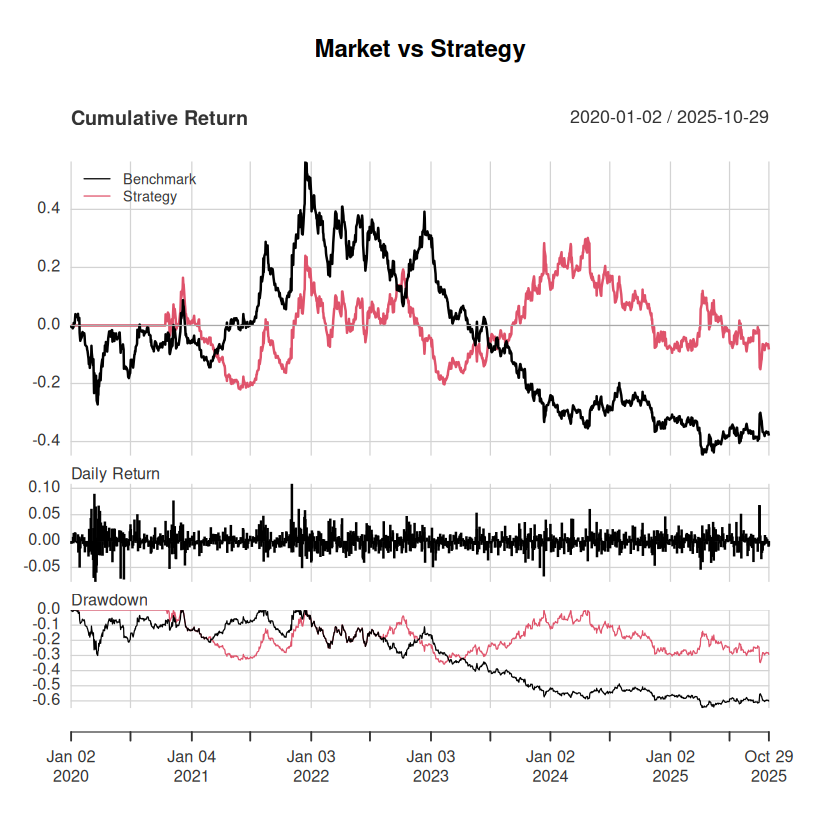

In [159]:
pfe_xts = xts(df_pfe_slow_fast_ma$prccd, df_pfe_slow_fast_ma$datadate)
signals = sign(f_fast_MA(pfe_xts) - f_slow_MA(pfe_xts))

charts.PerformanceSummary(backtest(pfe_xts, signals),
                          main = "Market vs Strategy")


## For top marks:
1. Use a loop to optimise the fast and slow window sizes to find the best performing strategy. The best solutions will consider all combinations of fast window sizes 20, 30, 40, 50 and slow window sizes 60, 90, 120, 150. Do not numerically or graphically show the performance for each combination of window sizes but do show the code used for optimising window sizes. Do plot the performance summary for the best performing strategy.

2. Create a line plot to help visualise where the moving average crossovers occur in your chosen strategy.

for loop

In [175]:
c_w_fast = c(20, 30, 40, 50)
c_w_slow = c(60, 90, 120, 150)

results = data.frame(fast = c_w_fast, slow = c_w_slow, profit = NA)

pfe_xts = xts(data_pfe_2020$prccd, order.by = data_pfe_2020$datadate)

for (w_fast in c_w_fast) {
    for (w_slow in c_w_slow) {

        fast_ma = f_fast_MA(pfe_xts, w_fast)
        slow_ma = f_slow_MA(pfe_xts, w_slow)

        sign = signals(fast_ma, slow_ma)

        profit = strategyReturns(pfe_xts, sign)

        results = rbind(results, data.frame(fast = w_fast, slow = w_slow, profit = profit))
        
        cat("Fast:", w_fast, "Slow:", w_slow, "→ Profit:", round(profit, 4), "\n")
    }
}

# Best-performing combination
best = results[which.max(results$profit), ]
cat("\nBest strategy → Fast:", best$fast, "Slow:", best$slow, "Profit:", round(best$profit, 4))


Fast: 20 Slow: 60 → Profit: -0.5431 
Fast: 20 Slow: 90 → Profit: -0.69 
Fast: 20 Slow: 120 → Profit: -0.4763 
Fast: 20 Slow: 150 → Profit: -0.5012 
Fast: 30 Slow: 60 → Profit: -0.6035 
Fast: 30 Slow: 90 → Profit: -0.4669 
Fast: 30 Slow: 120 → Profit: -0.1546 
Fast: 30 Slow: 150 → Profit: 0.1586 
Fast: 40 Slow: 60 → Profit: -0.5694 
Fast: 40 Slow: 90 → Profit: -0.6592 
Fast: 40 Slow: 120 → Profit: -0.2486 
Fast: 40 Slow: 150 → Profit: 0.0444 
Fast: 50 Slow: 60 → Profit: -0.7099 
Fast: 50 Slow: 90 → Profit: -0.358 
Fast: 50 Slow: 120 → Profit: 0.1788 
Fast: 50 Slow: 150 → Profit: -0.0686 

Best strategy → Fast: 50 Slow: 120 Profit: 0.1788

line plot

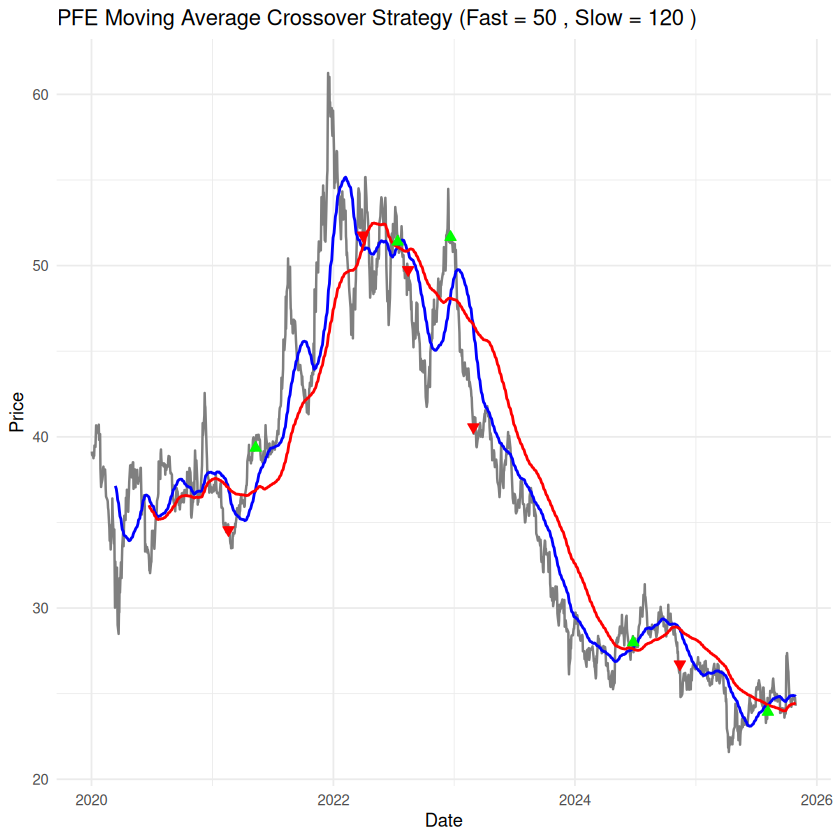

In [182]:
# Extract the best parameters
best_fast <- best$fast
best_slow <- best$slow

# Recalculate MAs and signals for the best combo
fast_best <- f_fast_MA(pfe_xts, window = best_fast)
slow_best <- f_slow_MA(pfe_xts, window = best_slow)
sig_best <- signals(fast_best, slow_best)

# Identify crossover points (buy/sell signals)
crossover_points <- which(diff(sig_best) != 0)
buy_points <- crossover_points[sig_best[crossover_points + 1] == 1]
sell_points <- crossover_points[sig_best[crossover_points + 1] == -1]

# Convert to data frame for ggplot
plot_data <- data.frame(
  Date = index(pfe_xts),
  Price = as.numeric(pfe_xts),
  Fast_MA = as.numeric(fast_best),
  Slow_MA = as.numeric(slow_best)
)

# Plot price, MAs, crossovers and signals
ggplot(plot_data, aes(x = Date)) +
  geom_line(aes(y = Price), color = "grey50", linewidth = 0.7) +
  geom_line(aes(y = Fast_MA), color = "blue", linewidth = 0.8) +
  geom_line(aes(y = Slow_MA), color = "red", linewidth = 0.8) +
  geom_point(data = plot_data[buy_points, ], aes(y = Price), color = "green", size = 2, shape = 24, fill = "green") +
  geom_point(data = plot_data[sell_points, ], aes(y = Price), color = "red", size = 2, shape = 25, fill = "red") +
  labs(
    title = paste("PFE Moving Average Crossover Strategy (Fast =", best_fast, ", Slow =", best_slow, ")"),
    y = "Price",
    x = "Date"
  ) +
  theme_minimal()


## Statement of Acknowledgment
I acknowledge the use of Microsoft Copilot (Microsoft,  https://copilot.microsoft.com/) to generate a function that will compute signals for a Bollinger Bands Breakout Strategy. I confirm that no content generated by AI has been presented as my own work. 

Bollinger Bands Breakout Strategy - Copilot Output

In [ ]:
bollinger_signals <- function(xts_prices, window = 20, k = 2) {
  # Compute rolling mean and standard deviation
  ma <- rollapplyr(xts_prices, width = window, FUN = mean, fill = NA, align = "right")
  sd <- rollapplyr(xts_prices, width = window, FUN = sd, fill = NA, align = "right")
  
  # Upper and lower bands
  upper_band <- ma + k * sd
  lower_band <- ma - k * sd
  
  # Generate signals: 1 = buy, -1 = sell, 0 = hold
  sig <- ifelse(xts_prices > upper_band, 1,
                ifelse(xts_prices < lower_band, -1, 0))
  
  return(xts(sig, order.by = index(xts_prices)))
}
